In [14]:
%matplotlib inline
from matplotlib.pyplot import *
import numpy as np
from scipy.linalg import svd

# This is a robust PCA implementation, adapted from 
https://github.com/dfm/pcp/blob/master/pcp.py

In [4]:
import time
import logging
import numpy as np
from scipy.sparse.linalg import svds

def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method = "exact", **svd_args):
    # Check the SVD method.a
    allowed_methods = ["exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        pass
     #   logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    # used to reduce the absolute value of M by tau
    # 
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

# RPCA

сonstruct a random rank-r matrix: let A ∈ R
m×n with aij ∼ N (0, 1) whose top-r
singular value/vector is λi
, ui ∈ R
m and vi ∈ R
n
(i = 1, . . . , r), define L =
Pr
i=1 uiv
T
i
. Construct
a sparse matrix E with p percentage (p ∈ [0, 1]) nonzero entries distributed uniformly.
Then define
M = L + E.
(a) Set m = n = 20, r = 1, and p = 0.1, use Matlab toolbox CVX to formulate a semidefinite
program for Robust PCA of M:

In [5]:
m = 20 # dims
n = 20

p0 = 0.05 # non-zero prob
p1 = 0.25

r0 = 1 # rank
r1 = 20

nn = 20 # number of points to sample
rep = 10 # repeats for probability estimate

probs = [] # recovery

for p in np.linspace(p0, p1, nn):
    for r in range(r0, r1):
        i = 0
        for _ in range(rep):

            A = np.random.normal(size = (m, n))
            U, s, VT = svd(A, full_matrices = False)
            L = np.dot(U[:r].reshape((U.shape[1], r)), (VT[:r]))

            E = np.random.normal(size = (m, n))
            zeros = np.random.rand(n, m)
            E[zeros > p] = 0

            M = L + E

            RPCA = pcp(M, svd_method = "exact") # return L, S, (u, s, v)

            if np.allclose(RPCA[0], L, atol=1e-5) \
                and np.allclose(RPCA[1], E, atol=1e-5):
                i += 1.
        probs.append(i / rep)     


In [12]:
ps = np.array(probs).reshape(nn,r1-r0)

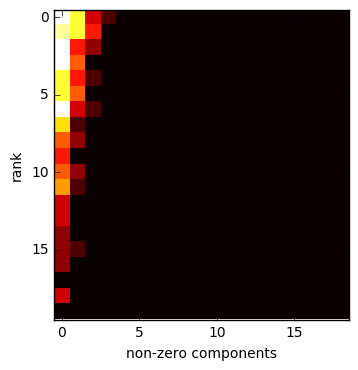

In [18]:
imshow(ps, cmap='hot', interpolation='nearest')
xlabel('non-zero components')
ylabel('rank')

# SPCA 

In [34]:
V1 = np.random.normal(0,290)
V2 = np.random.normal(0,300)
e = np.random.normal()
V3 = -0.3*V1 + 0.925*V2 + e

n_samples = 1000

In [ ]:
hidden = []

In [35]:
observed = []
for _ in range(n_samples):
    sample = [V1 + np.random.normal() for i in range(0,4)]
    sample += [V2 + np.random.normal() for i in range(4,8)]
    sample += [V3 + np.random.normal() for i in range(8,10)]
    observed.append(sample)
observed = np.array(observed)

In [39]:
o = observed - observed.mean(axis = 0)

In [60]:
sigma = np.dot(observed.T, observed)

In [61]:
sigma

array([[  1.63834699e+08,   1.63830178e+08,   1.63829172e+08,
          1.63832406e+08,   1.64045010e+08,   1.64053407e+08,
          1.64057008e+08,   1.64031670e+08,   1.02674067e+08,
          1.02683039e+08],
       [  1.63830178e+08,   1.63827597e+08,   1.63825686e+08,
          1.63828783e+08,   1.64041447e+08,   1.64049839e+08,
          1.64053445e+08,   1.64028189e+08,   1.02671770e+08,
          1.02680783e+08],
       [  1.63829172e+08,   1.63825686e+08,   1.63825625e+08,
          1.63827790e+08,   1.64040421e+08,   1.64048798e+08,
          1.64052389e+08,   1.64027165e+08,   1.02671171e+08,
          1.02680167e+08],
       [  1.63832406e+08,   1.63828783e+08,   1.63827790e+08,
          1.63831999e+08,   1.64043658e+08,   1.64052064e+08,
          1.64055617e+08,   1.64030327e+08,   1.02673157e+08,
          1.02682183e+08],
       [  1.64045010e+08,   1.64041447e+08,   1.64040421e+08,
          1.64043658e+08,   1.64257588e+08,   1.64264919e+08,
          1.64268575e+08

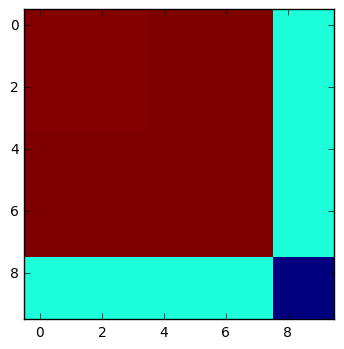

In [62]:
imshow(sigma, interpolation="nearest")

In [63]:
eigenval, eigenvec = np.linalg.eig(sigma)

In [65]:
eigenvec[0]

array([ 0.33717928,  0.23828762, -0.08031946,  0.47965576, -0.48279128,
       -0.01157829,  0.19708156, -0.27625177,  0.49310948, -0.03838836])